# Test `tide_stn_water_level` Module

Render figure object produced by the `nowcast.figures.fvcom.tide_stn_water_level` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Vancouver Harbour & Fraser River FVCOM model results `/opp/` parition mounted.

In [1]:
import io
from pathlib import Path
import shlex
import subprocess

import arrow
import xarray
import yaml

from nowcast.figures import website_theme
from nowcast.figures.fvcom.publish import tide_stn_water_level

In [2]:
%matplotlib inline

In [3]:
# Supress arrow.get() parser warnings re: changes coming in v0.15.0
# See https://github.com/crsmithdev/arrow/issues/612
# We don't use date strings that aren't included in the supported date tokens set mentioned in issue #612

import warnings
from arrow.factory import ArrowParseWarning

warnings.simplefilter("ignore", ArrowParseWarning)

The bits of `config/nowcast.yaml` that are required:

In [4]:
config = '''
    figures:
        dataset URLs:
            HRDPS fields: https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1
            tide stn ssh time series:
                # **Must be quoted to project {} characters**
                'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf{place}SSH10mV18-06'
                
    vhfr fvcom runs:
        stations dataset filename:
            x2: vh_x2_station_timeseries.nc
            r12: vh_r12_station_timeseries.nc
        results archive:
            nowcast x2: /opp/fvcom/nowcast-x2/
            forecast x2: /opp/fvcom/forecast-x2/
            nowcast r12: /opp/fvcom/nowcast-r12/
'''

config = yaml.safe_load(io.StringIO(config))

The bits that the `make_figures` worker must provide:

Rename FVCOM dataset layer and leval variables because `xarray` won't accept
variables and coordinates that have the same name.

In [5]:
def _rename_fvcom_vars(fvcom_dataset_path):
    cmd = (
        f'ncrename -O -v siglay,sigma_layer -v siglev,sigma_level '
        f'{fvcom_dataset_path} /tmp/{fvcom_dataset_path.name}')
    subprocess.check_output(shlex.split(cmd))

### Nowcast `X2` Figure

In [6]:
run_date = arrow.get('2019-07-28')
model_config = "x2"
run_type = 'nowcast'

ddmmmyy = run_date.format('DDMMMYY').lower()

fvcom_stns_datasets = {}
if run_type == 'nowcast':
    model_configs = ("x2", "r12") if model_config == "r12" else ("x2",)
    for mdl_cfg in model_configs:
        fvcom_stns_dataset_filename = config['vhfr fvcom runs']['stations dataset filename'][mdl_cfg]
        results_dir = Path(
            config['vhfr fvcom runs']['results archive'][f"{run_type} {mdl_cfg}"], ddmmmyy
        )
        fvcom_stns_dataset_path = results_dir / fvcom_stns_dataset_filename
        _rename_fvcom_vars(fvcom_stns_dataset_path)
        fvcom_stns_datasets[mdl_cfg] = xarray.open_dataset(f'/tmp/{fvcom_stns_dataset_path.name}')
else:
    fvcom_stns_dataset_filename = config['vhfr fvcom runs']['stations dataset filename']["x2"]
    nowcast_results_dir = Path(
        config['vhfr fvcom runs']['results archive']['nowcast x2'], ddmmmyy
    )
    nowcast_dataset_path = (nowcast_results_dir/fvcom_stns_dataset_filename)
    forecast_results_dir = Path(
        config['vhfr fvcom runs']['results archive']['forecast x2'], ddmmmyy
    )
    forecast_dataset_path = (forecast_results_dir/fvcom_stns_dataset_filename)
    fvcom_stns_dataset_path = Path("/tmp", fvcom_stns_dataset_filename)
    cmd = (
        f'ncrcat -O {nowcast_dataset_path} {forecast_dataset_path} '
        f'-o {fvcom_stns_dataset_path}'
    )
    subprocess.check_output(shlex.split(cmd))
    _rename_fvcom_vars(fvcom_stns_dataset_path)
    fvcom_stns_datasets[model_config] = xarray.open_dataset(f'/tmp/{fvcom_stns_dataset_path.name}')

nemo_ssh_dataset_url_tmpl = config['figures']['dataset URLs']['tide stn ssh time series']

52.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


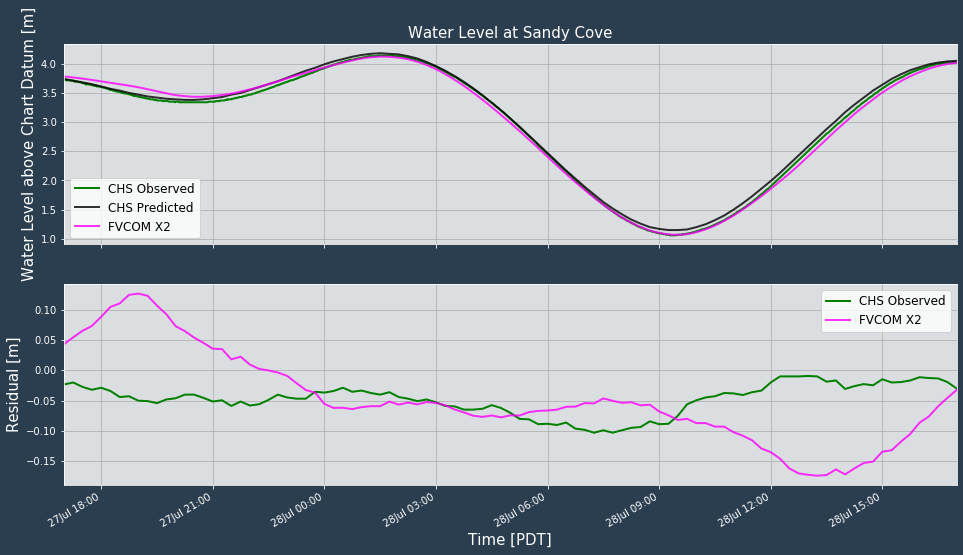

In [7]:
%%timeit -n1 -r1

from importlib import reload
reload(website_theme)
reload(tide_stn_water_level)

fig = tide_stn_water_level.make_figure('Sandy Cove', fvcom_stns_datasets, nemo_ssh_dataset_url_tmpl)

3min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


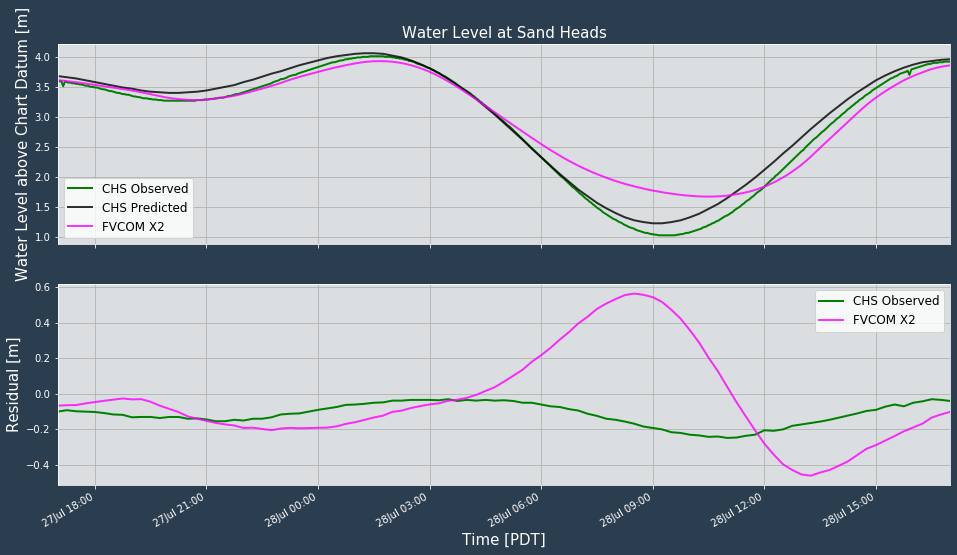

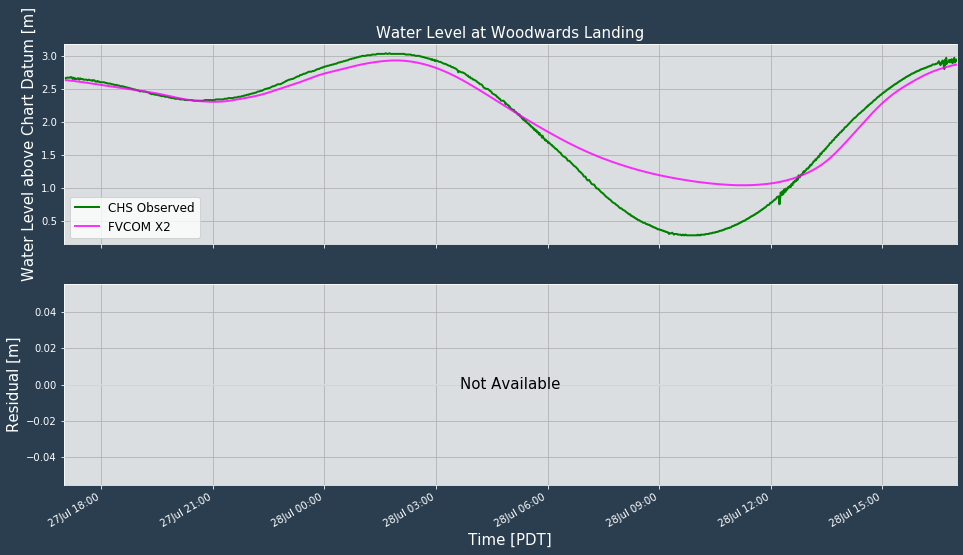

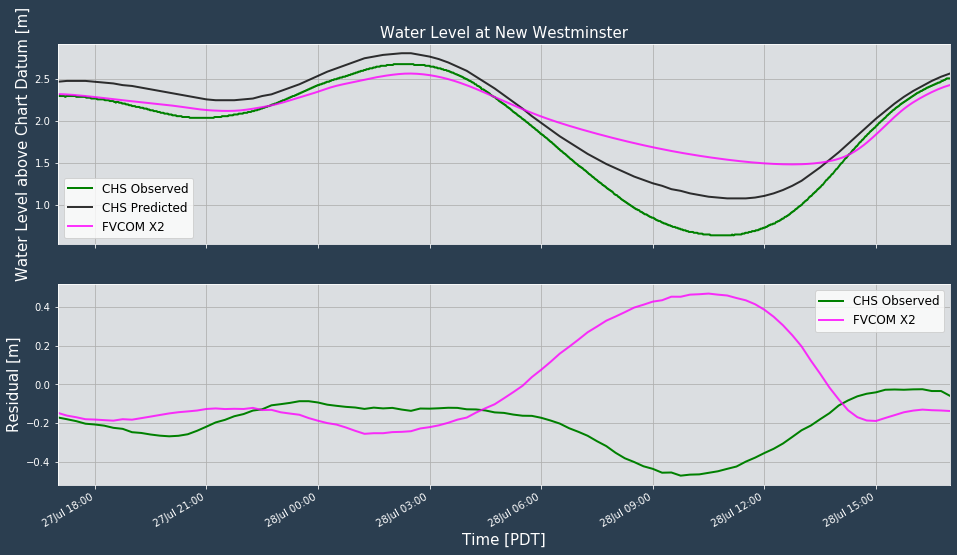

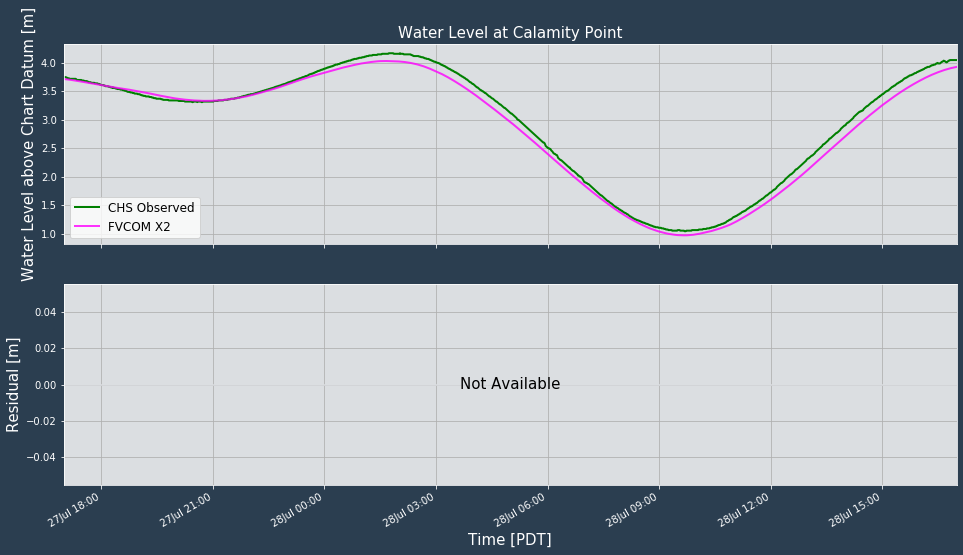

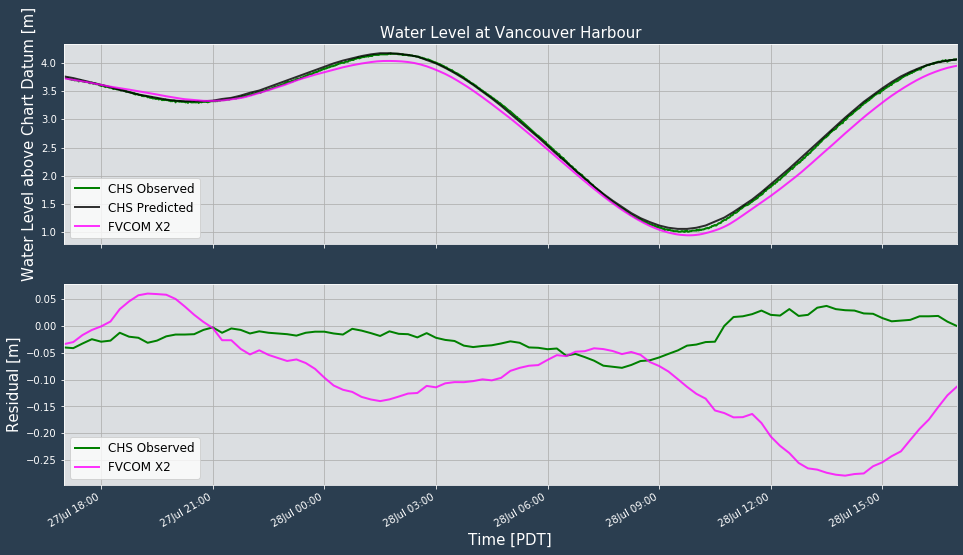

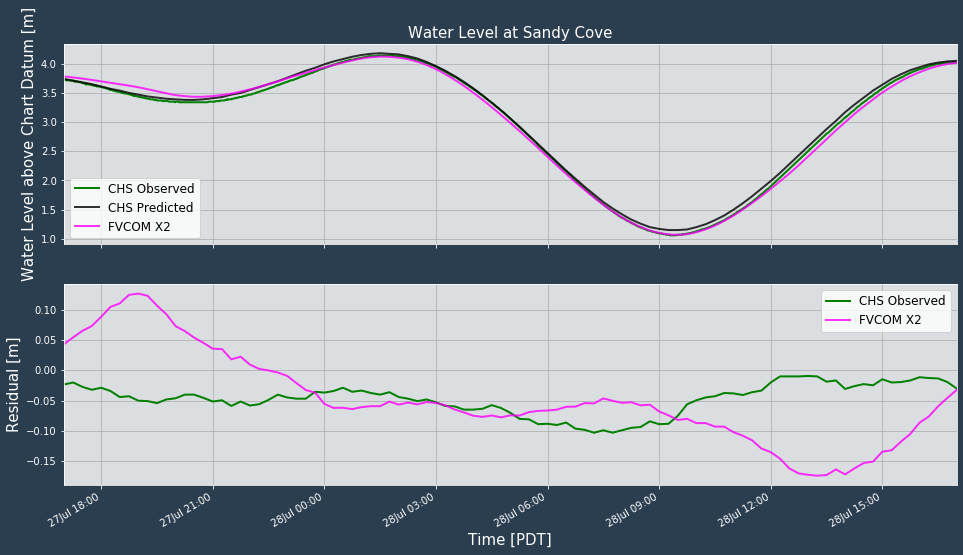

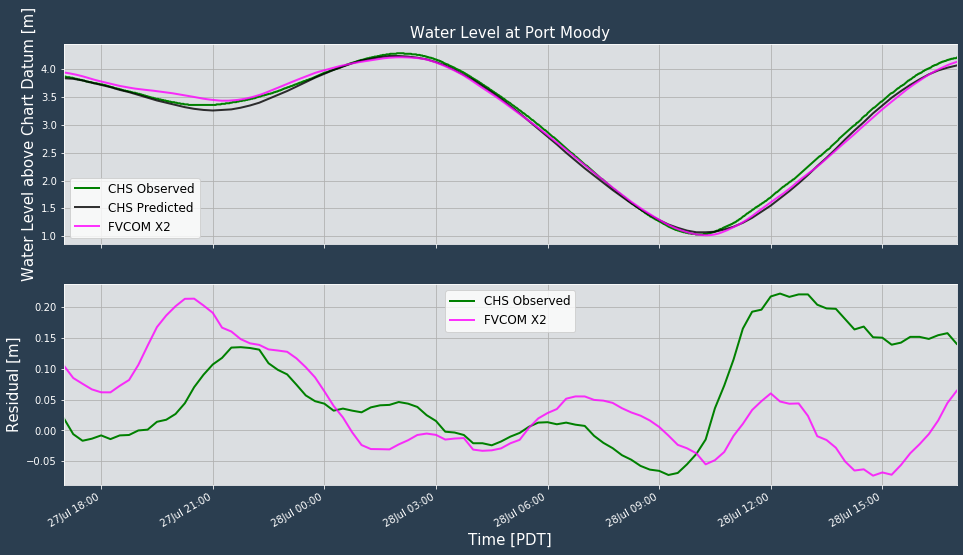

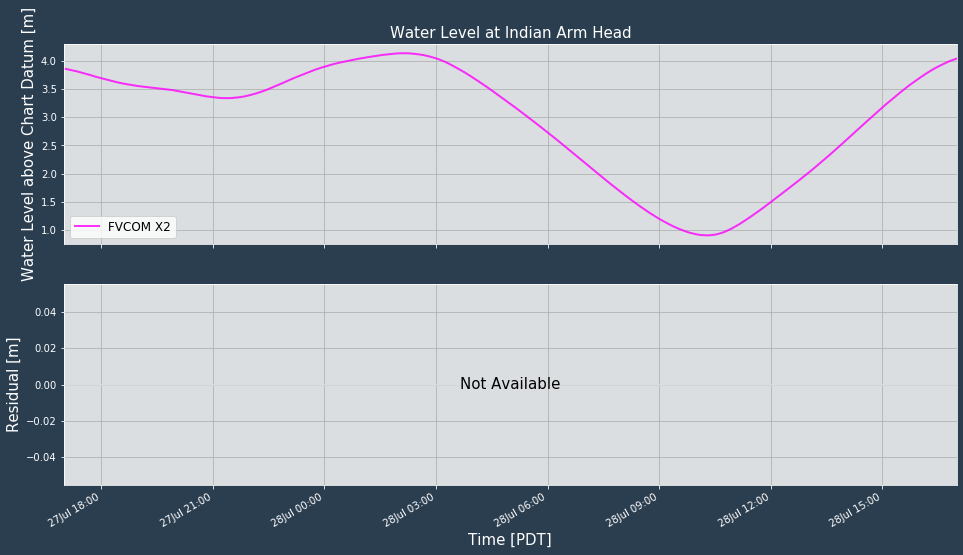

In [8]:
%%timeit -n1 -r1

from importlib import reload
reload(website_theme)
reload(tide_stn_water_level)

stations = [
    name.decode().strip().split(maxsplit=1)[1]
    for name in fvcom_stns_datasets["x2"].name_station.values
]
stations.remove('2nd Narrows')
for station in stations:
    fig = tide_stn_water_level.make_figure(station, fvcom_stns_datasets, nemo_ssh_dataset_url_tmpl)

### Nowcast `R12` Figure

In [9]:
run_date = arrow.get('2019-07-28')
model_config = "r12"
run_type = 'nowcast'

ddmmmyy = run_date.format('DDMMMYY').lower()

fvcom_stns_datasets = {}
if run_type == 'nowcast':
    model_configs = ("x2", "r12") if model_config == "r12" else ("x2",)
    for mdl_cfg in model_configs:
        fvcom_stns_dataset_filename = config['vhfr fvcom runs']['stations dataset filename'][mdl_cfg]
        results_dir = Path(
            config['vhfr fvcom runs']['results archive'][f"{run_type} {mdl_cfg}"], ddmmmyy
        )
        fvcom_stns_dataset_path = results_dir / fvcom_stns_dataset_filename
        _rename_fvcom_vars(fvcom_stns_dataset_path)
        fvcom_stns_datasets[mdl_cfg] = xarray.open_dataset(f'/tmp/{fvcom_stns_dataset_path.name}')
else:
    fvcom_stns_dataset_filename = config['vhfr fvcom runs']['stations dataset filename']["x2"]
    nowcast_results_dir = Path(
        config['vhfr fvcom runs']['results archive']['nowcast x2'], ddmmmyy
    )
    nowcast_dataset_path = (nowcast_results_dir/fvcom_stns_dataset_filename)
    forecast_results_dir = Path(
        config['vhfr fvcom runs']['results archive']['forecast x2'], ddmmmyy
    )
    forecast_dataset_path = (forecast_results_dir/fvcom_stns_dataset_filename)
    fvcom_stns_dataset_path = Path("/tmp", fvcom_stns_dataset_filename)
    cmd = (
        f'ncrcat -O {nowcast_dataset_path} {forecast_dataset_path} '
        f'-o {fvcom_stns_dataset_path}'
    )
    subprocess.check_output(shlex.split(cmd))
    _rename_fvcom_vars(fvcom_stns_dataset_path)
    fvcom_stns_datasets[model_config] = xarray.open_dataset(f'/tmp/{fvcom_stns_dataset_path.name}')

nemo_ssh_dataset_url_tmpl = config['figures']['dataset URLs']['tide stn ssh time series']

57.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


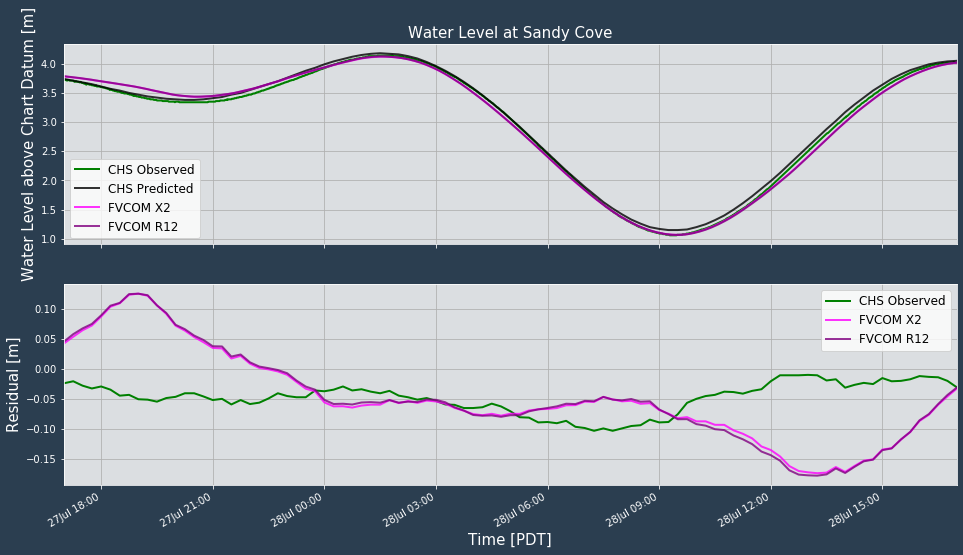

In [10]:
%%timeit -n1 -r1

from importlib import reload
reload(website_theme)
reload(tide_stn_water_level)

fig = tide_stn_water_level.make_figure('Sandy Cove', fvcom_stns_datasets, nemo_ssh_dataset_url_tmpl)

3min 11s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


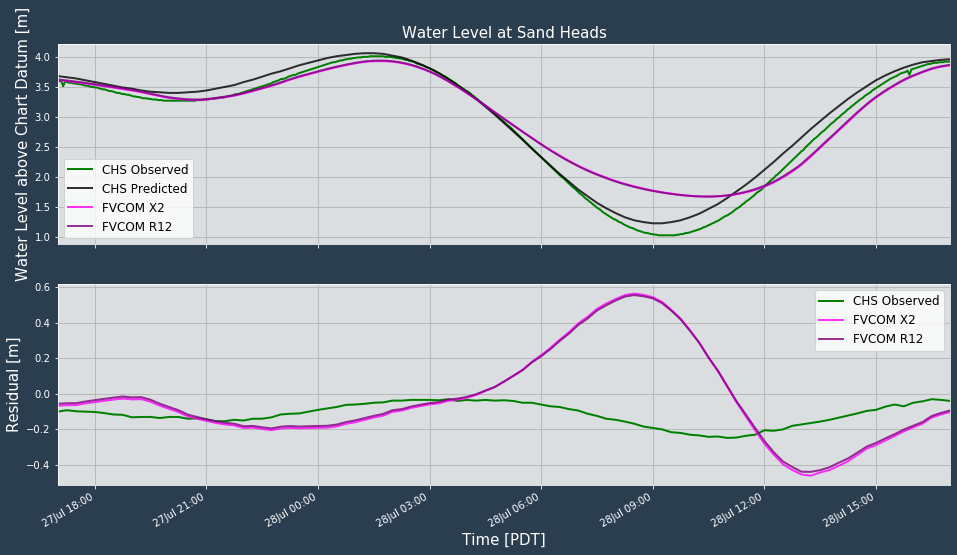

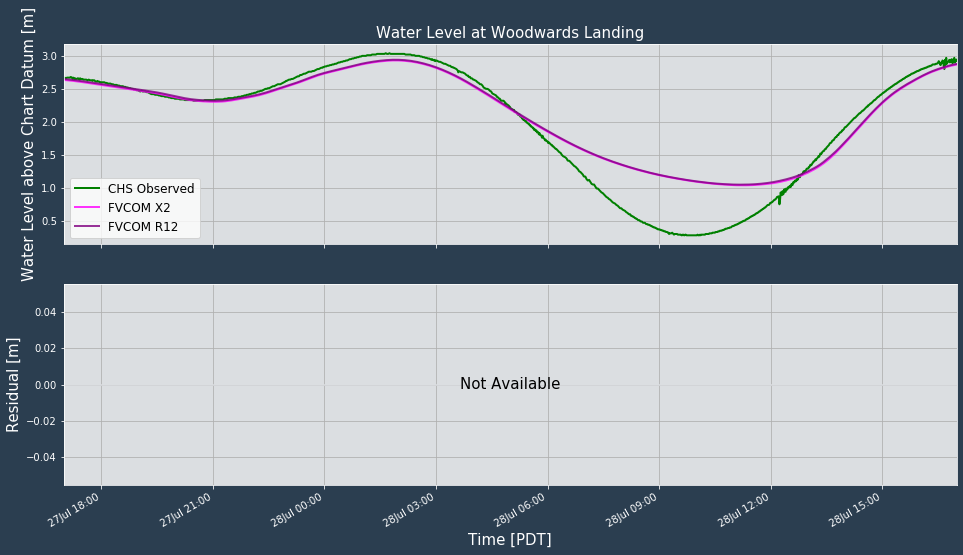

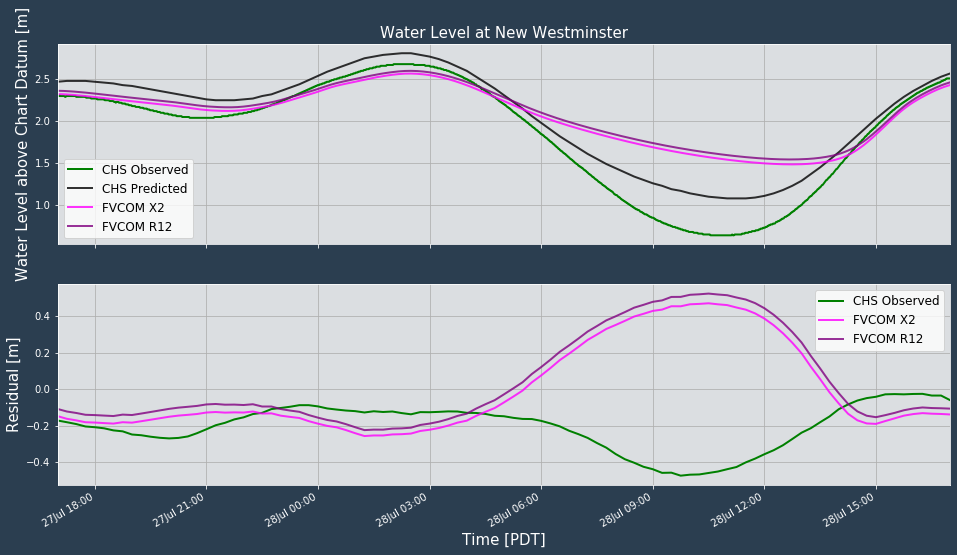

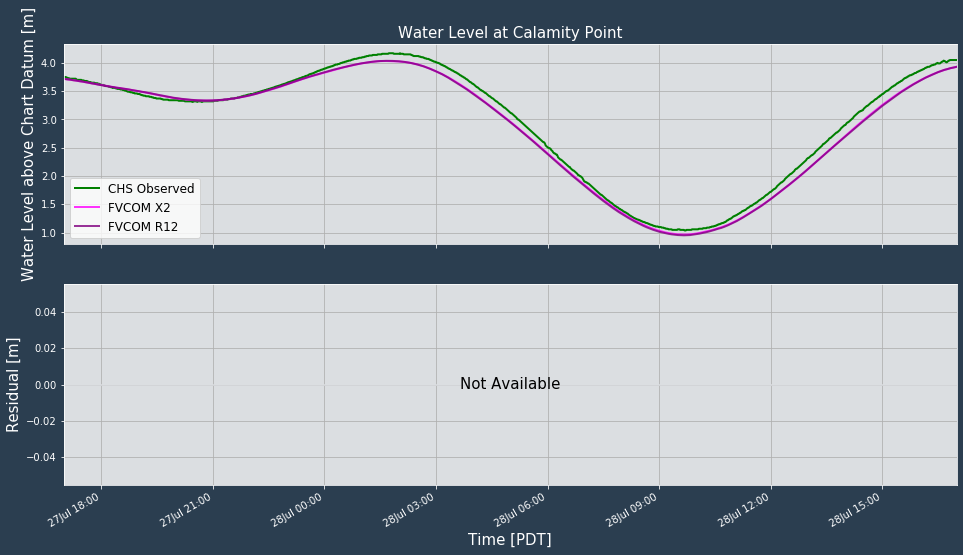

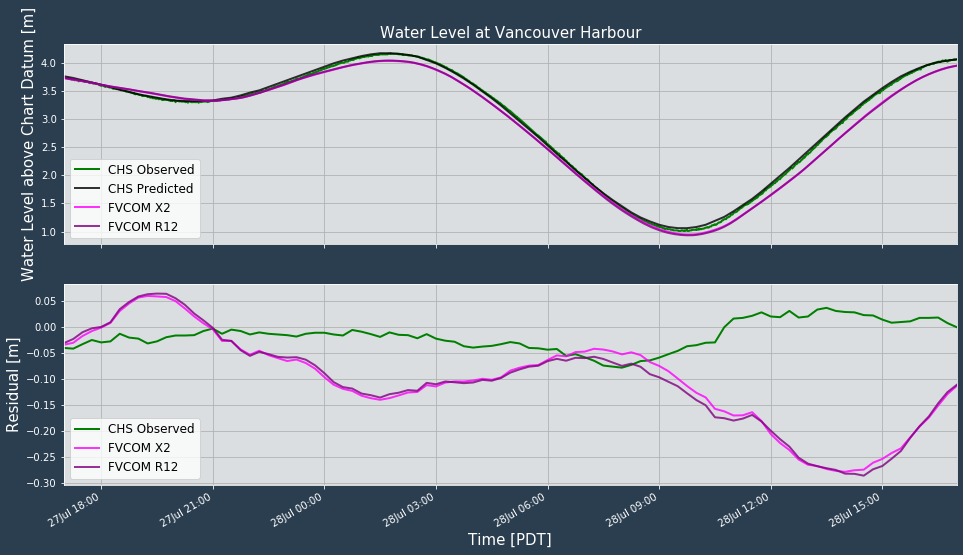

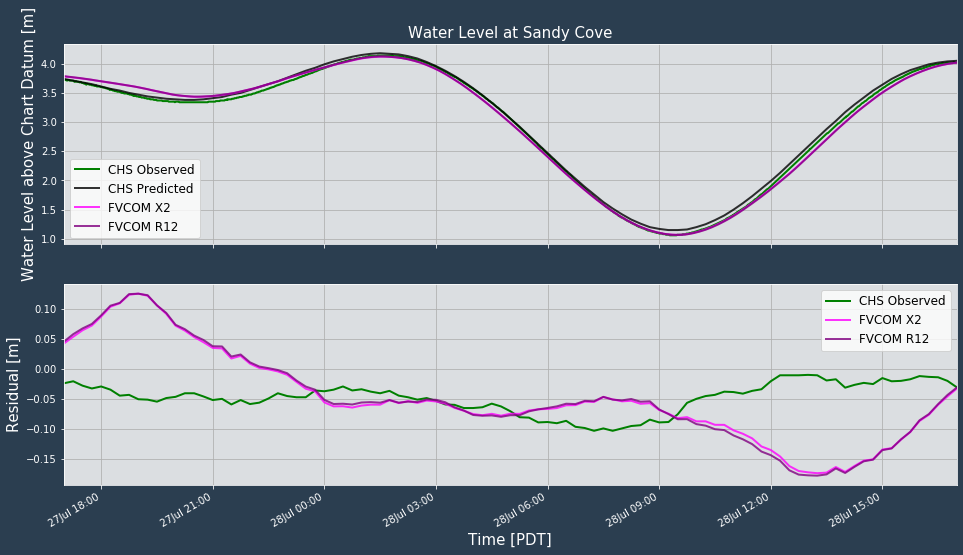

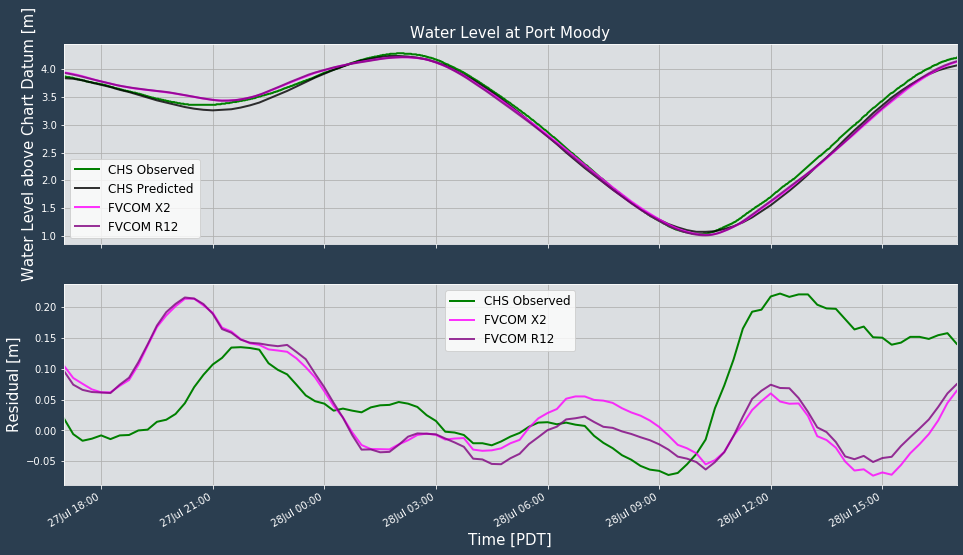

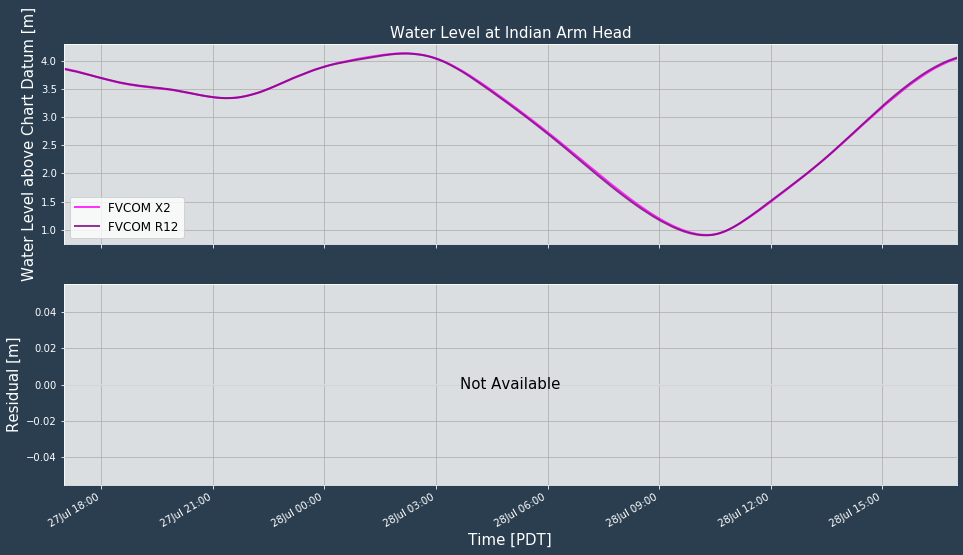

In [11]:
%%timeit -n1 -r1

from importlib import reload
reload(website_theme)
reload(tide_stn_water_level)

stations = [
    name.decode().strip().split(maxsplit=1)[1]
    for name in fvcom_stns_datasets["x2"].name_station.values
]
stations.remove('2nd Narrows')
for station in stations:
    fig = tide_stn_water_level.make_figure(station, fvcom_stns_datasets, nemo_ssh_dataset_url_tmpl)

### Forecast `X2` Figure

In [12]:
run_date = arrow.get('2019-07-28')
model_config = "x2"
run_type = 'forecast'

ddmmmyy = run_date.format('DDMMMYY').lower()

fvcom_stns_datasets = {}
if run_type == 'nowcast':
    model_configs = ("x2", "r12") if model_config == "r12" else ("x2",)
    for mdl_cfg in model_configs:
        fvcom_stns_dataset_filename = config['vhfr fvcom runs']['stations dataset filename'][mdl_cfg]
        results_dir = Path(
            config['vhfr fvcom runs']['results archive'][f"{run_type} {mdl_cfg}"], ddmmmyy
        )
        fvcom_stns_dataset_path = results_dir / fvcom_stns_dataset_filename
        _rename_fvcom_vars(fvcom_stns_dataset_path)
        fvcom_stns_datasets[mdl_cfg] = xarray.open_dataset(f'/tmp/{fvcom_stns_dataset_path.name}')
else:
    fvcom_stns_dataset_filename = config['vhfr fvcom runs']['stations dataset filename']["x2"]
    nowcast_results_dir = Path(
        config['vhfr fvcom runs']['results archive']['nowcast x2'], ddmmmyy
    )
    nowcast_dataset_path = (nowcast_results_dir/fvcom_stns_dataset_filename)
    forecast_results_dir = Path(
        config['vhfr fvcom runs']['results archive']['forecast x2'], ddmmmyy
    )
    forecast_dataset_path = (forecast_results_dir/fvcom_stns_dataset_filename)
    fvcom_stns_dataset_path = Path("/tmp", fvcom_stns_dataset_filename)
    cmd = (
        f'ncrcat -O {nowcast_dataset_path} {forecast_dataset_path} '
        f'-o {fvcom_stns_dataset_path}'
    )
    subprocess.check_output(shlex.split(cmd))
    _rename_fvcom_vars(fvcom_stns_dataset_path)
    fvcom_stns_datasets[model_config] = xarray.open_dataset(f'/tmp/{fvcom_stns_dataset_path.name}')

nemo_ssh_dataset_url_tmpl = config['figures']['dataset URLs']['tide stn ssh time series']

24.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


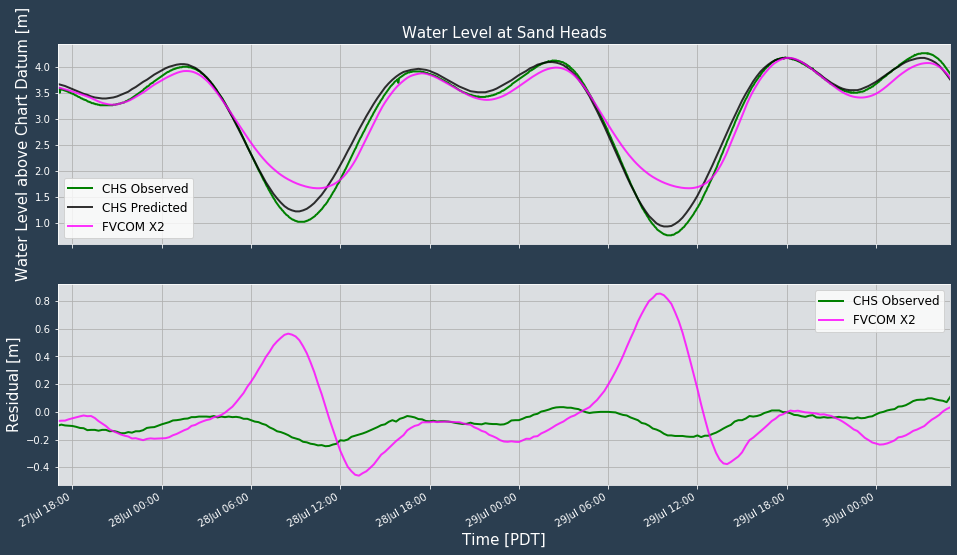

In [13]:
%%timeit -n1 -r1

from importlib import reload
reload(website_theme)
reload(tide_stn_water_level)

fig = tide_stn_water_level.make_figure('Sand Heads', fvcom_stns_datasets, nemo_ssh_dataset_url_tmpl)

5min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


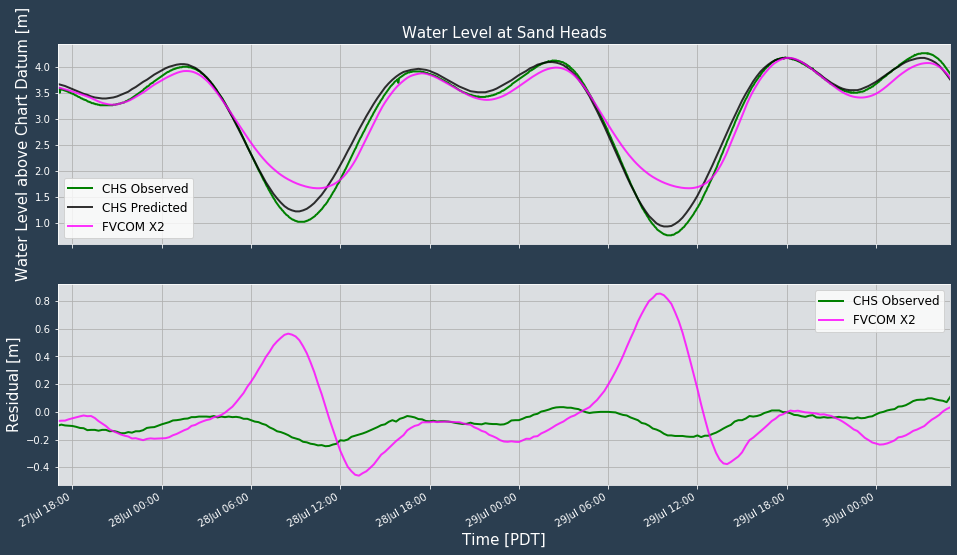

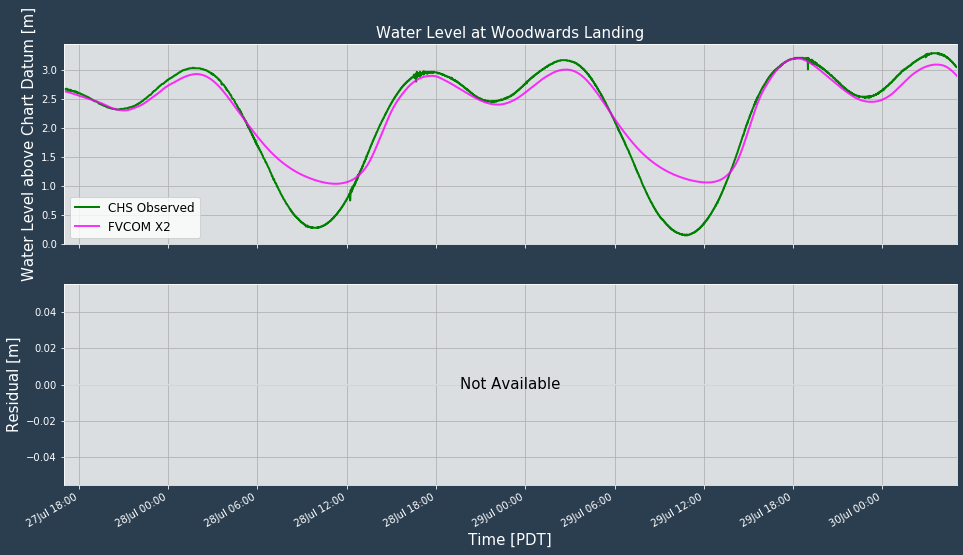

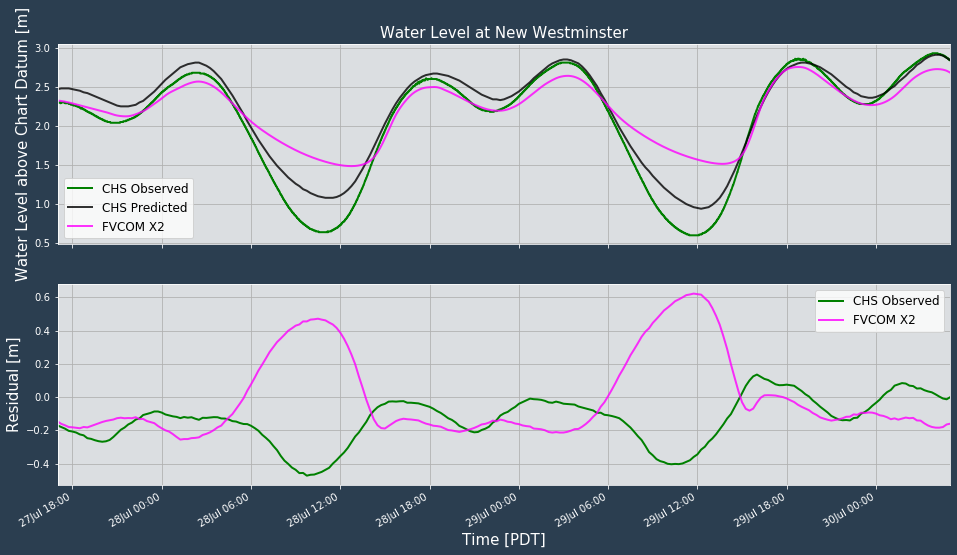

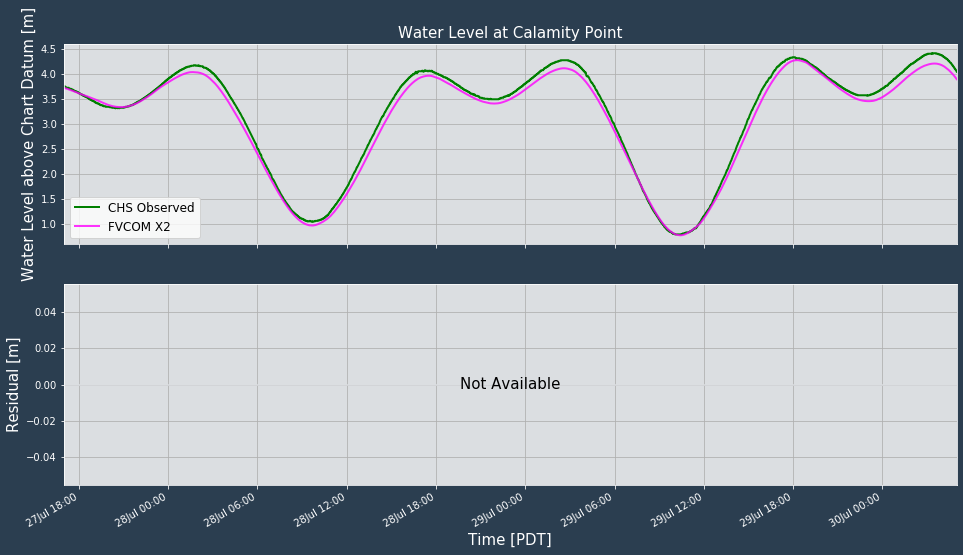

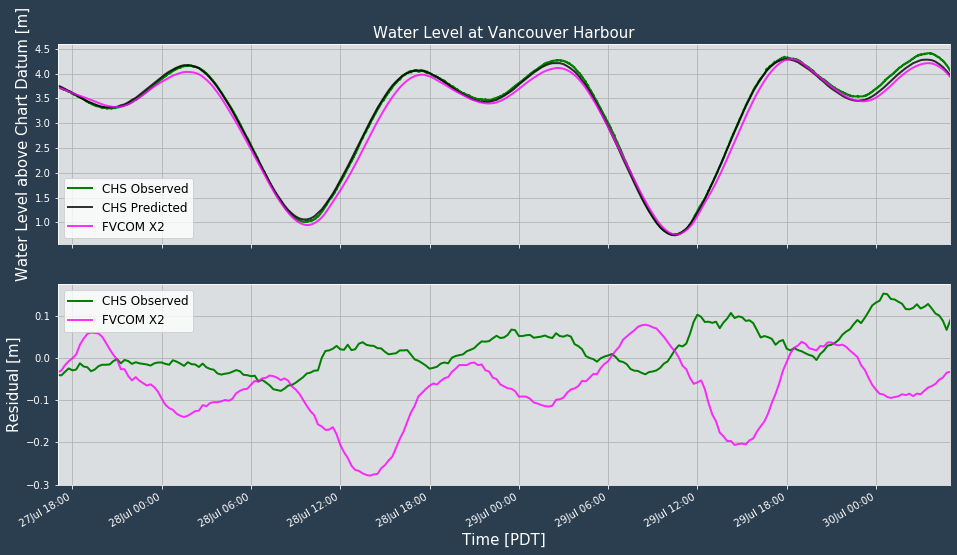

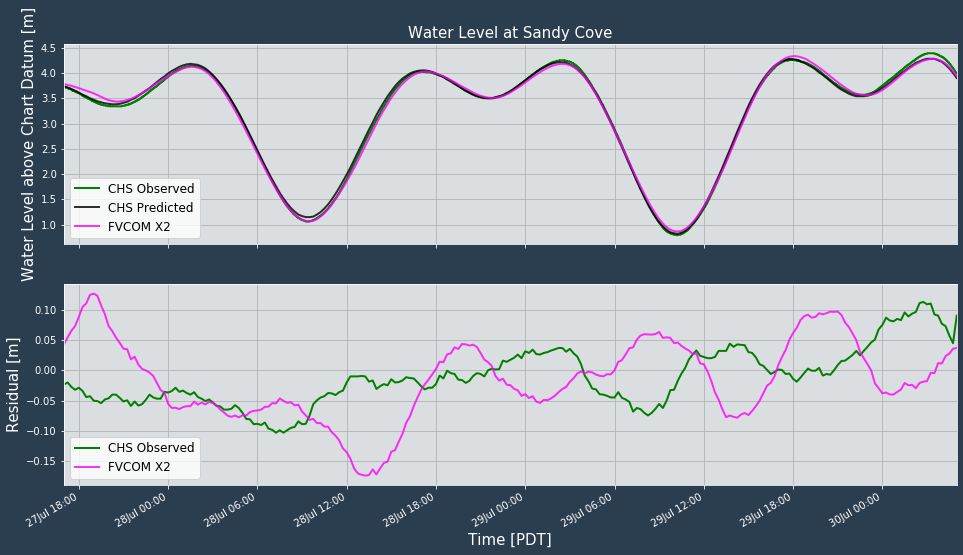

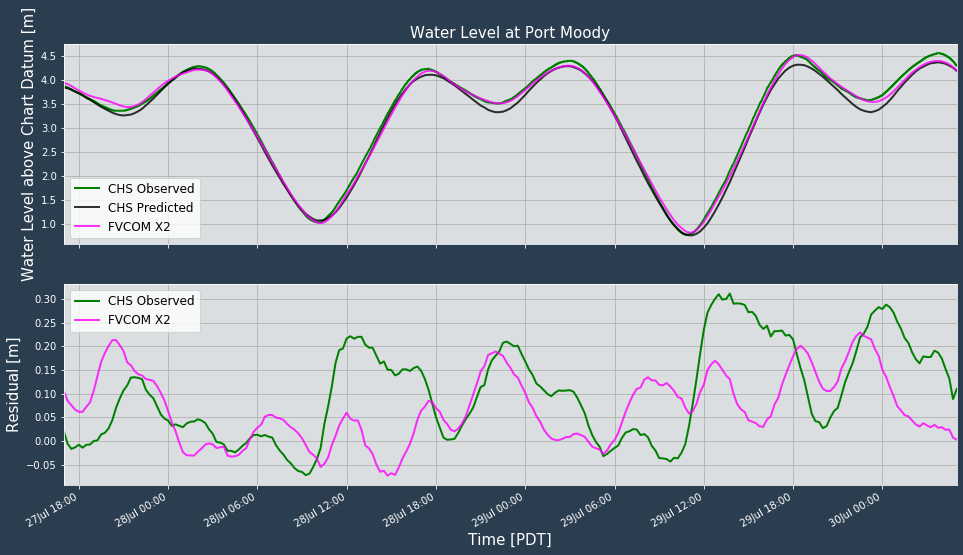

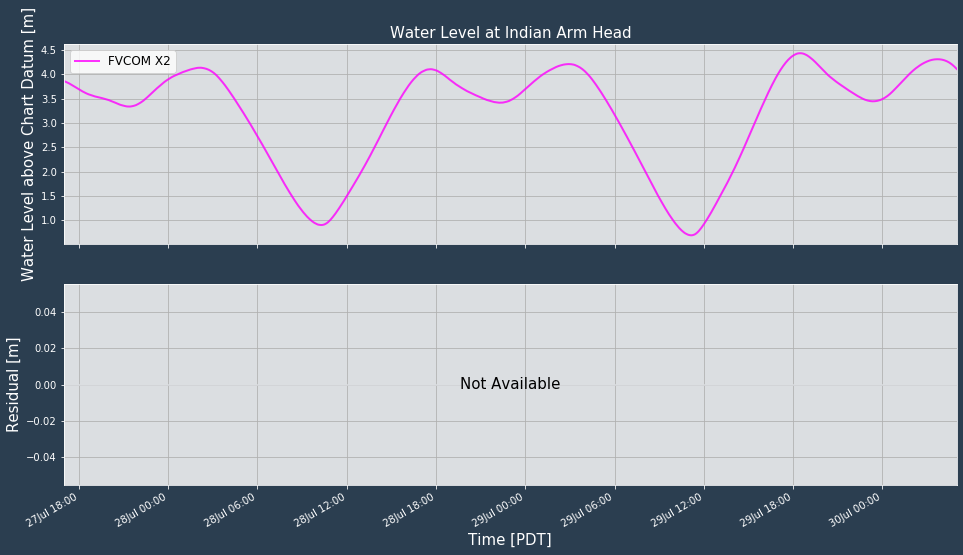

In [14]:
%%timeit -n1 -r1

from importlib import reload
reload(website_theme)
reload(tide_stn_water_level)

stations = [
    name.decode().strip().split(maxsplit=1)[1]
    for name in fvcom_stns_datasets["x2"].name_station.values
]
stations.remove('2nd Narrows')
for station in stations:
    fig = tide_stn_water_level.make_figure(station, fvcom_stns_datasets, nemo_ssh_dataset_url_tmpl)